In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import time
from sklearn.model_selection import train_test_split
import shutil
import random
from datetime import datetime

In [2]:
# Image Data Generator
num_classes = 2
image_resize = 224
batch_size_training = 32
batch_size_validation = 32
input_shape = (image_resize, image_resize, 3)
num_epochs = 5
learning_rate = 0.01
class_1 = "cat"
class_2 = "dog"
train_percent = 0.80
val_percent = 1 - train_percent

# Seeds
np.random.seed(42)
tf.random.set_seed(42)

# TensorBoard and MLflow Logging

def create_experiment(class_1, class_2):
    experiment_name = f"{class_1}_{class_2}_classification"
    return experiment_name

def create_runname(model_name):
    run_name = datetime.now().strftime(f"{model_name}_%Y_%m_%d__%H%M%S")
    return run_name

In [3]:
experiment_name = create_experiment(class_1, class_2)
print(experiment_name)

cat_dog_classification


In [4]:
current_directory = os.getcwd()
image_path = "datasets/images"

In [5]:
train_dir = os.path.join(image_path, 'train')
val_dir = os.path.join(image_path, 'validation')

# Ensure directories exist
for directory in [train_dir, val_dir]:
    os.makedirs(os.path.join(directory, class_1), exist_ok=True)
    os.makedirs(os.path.join(directory, class_2), exist_ok=True)

def move_images(source_dir, dest_dir, num_images):
    images = os.listdir(source_dir)
    random.shuffle(images)
    for image in images[:num_images]:
        src_path = os.path.join(source_dir, image)
        dest_path = os.path.join(dest_dir, image)
        try:
            shutil.move(src_path, dest_path)
        except PermissionError as e:
            print(f"Permission error occurred: {e}. Skipping file: {src_path}")
        else:
            if dest_path.lower().endswith('.png'):
                try:
                    img = Image.open(dest_path)
                    if img.mode != 'RGBA':
                        img = img.convert('RGBA')
                        img.save(dest_path)
                except Exception as e:
                    print(f"Error converting {dest_path}: {e}")

def split_images(image_path, train_dir, val_dir, train_percent, val_percent):
    for category in [class_1, class_2]:
        source_category_dir = os.path.join(image_path, category)
        train_category_dir = os.path.join(train_dir, category)
        val_category_dir = os.path.join(val_dir, category)

        num_images = len(os.listdir(source_category_dir))
        num_train = int(train_percent * num_images)
        num_val = int(val_percent * num_images)

        move_images(source_category_dir, train_category_dir, num_train)
        move_images(source_category_dir, val_category_dir, num_val)

split_images(image_path, train_dir, val_dir, train_percent, val_percent)
print("Images separated into train and validation directories successfully.")

Images separated into train and validation directories successfully.


In [6]:
# ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

In [7]:
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size_training,
    class_mode="categorical",
    shuffle=True
)

Found 19995 images belonging to 2 classes.


In [8]:
validation_generator = ImageDataGenerator().flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size_validation,
    class_mode="categorical",
    shuffle=True
)

Found 4998 images belonging to 2 classes.


In [9]:
# Adjust steps per epoch if necessary
steps_per_epoch_training = train_generator.samples // train_generator.batch_size
steps_per_epoch_validation = validation_generator.samples // validation_generator.batch_size

print(steps_per_epoch_training, steps_per_epoch_validation)

624 156


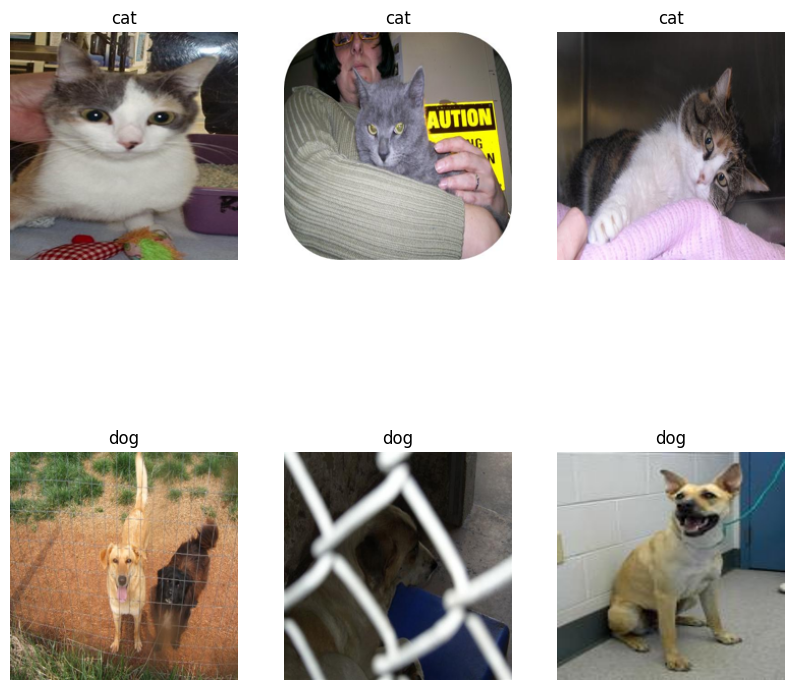

In [10]:
train_images = os.path.join(image_path, "train")

image_size = (image_resize, image_resize)

def display_images(directory):
    plt.figure(figsize=(10, 10))
    categories = os.listdir(directory)
    for category in categories:
        category_dir = os.path.join(directory, category)
        images = [file for file in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, file))]
        for i in range(3):
            img_name = random.choice(images)
            img_path = os.path.join(category_dir, img_name)

            img = Image.open(img_path)
            img = img.resize(image_size)

            plt.subplot(2, 3, categories.index(category) * 3 + i + 1)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
    plt.show()

display_images(train_images)

In [11]:
# Now, we need to prepare the data for Keras model training
def load_and_preprocess_data(image_path):
    X, y = [], []
    categories = [class_1, class_2]
    for category in categories:
        category_path = os.path.join(image_path, category)
        label = categories.index(category)
        for file in os.listdir(category_path):
            img_path = os.path.join(category_path, file)
            if os.path.isfile(img_path):
                img = Image.open(img_path)
                img = img.resize((image_resize, image_resize))
                img = np.array(img)
                if img.shape == (image_resize, image_resize, 3):  # Ensure all images are in the correct shape
                    X.append(img)
                    y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y



In [12]:
X_train, y_train = load_and_preprocess_data(train_dir)
X_test, y_test = load_and_preprocess_data(val_dir)

# Normalize the image data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Load NASNet model
base_model = tf.keras.applications.NASNetMobile(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])


# Model training
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation
)
keras_training_time = time.time() - start_time

c:\Users\MEHMET\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/5


c:\Users\MEHMET\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/624 ━━━━━━━━━━━━━━━━━━━━ 515s 796ms/step - accuracy: 0.5733 - loss: 1.2448 - val_accuracy: 0.6182 - val_loss: 0.6531
Epoch 2/5
  1/624 ━━━━━━━━━━━━━━━━━━━━ 4:13 407ms/step - accuracy: 0.5312 - loss: 0.7146

c:\Users\MEHMET\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - accuracy: 0.5312 - loss: 0.7146 - val_accuracy: 0.6667 - val_loss: 0.6539
Epoch 3/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 420s 671ms/step - accuracy: 0.5972 - loss: 0.6663 - val_accuracy: 0.5986 - val_loss: 0.6798
Epoch 4/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 211us/step - accuracy: 0.6250 - loss: 0.7255 - val_accuracy: 0.8333 - val_loss: 0.5983
Epoch 5/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 418s 668ms/step - accuracy: 0.6118 - loss: 0.6582 - val_accuracy: 0.6078 - val_loss: 0.6682


In [13]:
# Model evaluation
keras_accuracy = model.evaluate(validation_generator, steps=steps_per_epoch_validation)[1]

print(f"Keras training time: {keras_training_time} seconds")
print(f"Keras accuracy: {keras_accuracy}")

156/156 ━━━━━━━━━━━━━━━━━━━━ 64s 410ms/step - accuracy: 0.6022 - loss: 0.6706
Keras training time: 1355.6753778457642 seconds
Keras accuracy: 0.6077724099159241


In [14]:
# Save the model in the new format
model.save('keras_nasnet_model.keras', save_format='tf')

In [15]:
try:
    model = load_model('keras_nasnet_model.keras')
    model.summary()
except Exception as e:
    print(f"Error loading model: {e}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nasnet_mobile (Functional)      │ (None, 7, 7, 1056)     │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1056)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       135,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,676,380 (17.84 MB)

 Trainable params: 135,554 (529.51 KB)

 Non-trainable params: 4,269,716 (16.29 MB)

 Optimizer params: 271,110 (1.03 MB)